In [4]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_3d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


-----
-----
## Curated solubility dataset

##### Curated solubility dataset

In [5]:
from sklearn.preprocessing import StandardScaler
# load dataset
data = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/curated-solubility-dataset.csv"
)
x_data = data.loc[:, "MolWt":]
y_data = data["Solubility"]

n_var = x_data.shape[1]

ss_x, ss_y = StandardScaler(), StandardScaler()

x_data_scaled = ss_x.fit_transform(x_data.values)
y_data_scaled = ss_y.fit_transform(y_data.values.reshape(-1, 1))

dataset = {
    'train_input': torch.Tensor(x_data_scaled),
    'test_input': torch.Tensor(x_data_scaled),
    'train_label': torch.Tensor(y_data_scaled),
    'test_label': torch.Tensor(y_data_scaled),
}

-----
### MLP

№ model trainable params: 441


| train_loss: 4.00e-01 | test_loss: 5.32e-01 | reg: 1.71e+02 | : 100%|█| 100/100 [00:04<00:00, 24.08


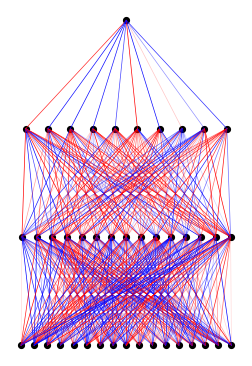

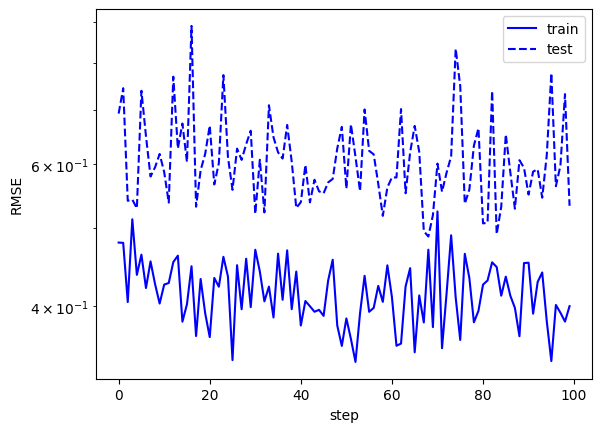

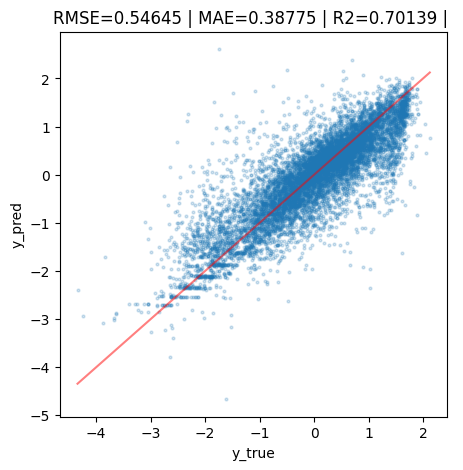

In [3]:
# initialize MLP
model = MLP(width=[n_var,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 1080


| train_loss: 3.86e-01 | test_loss: 5.66e-01 | reg: 4.07e+01 | : 100%|█| 100/100 [00:37<00:00,  2.68


saving model version 0.1


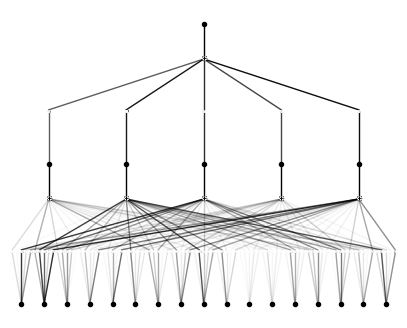

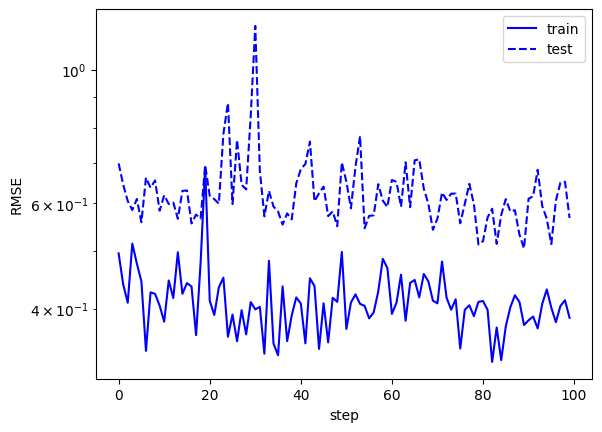

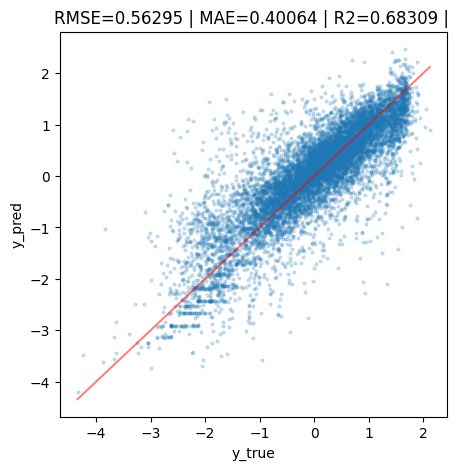

In [4]:
# initialize KAN with G=3
model = KAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 457


| train_loss: 5.27e-01 | test_loss: 5.92e-01 | reg: 2.98e+01 | : 100%|█| 150/150 [01:05<00:00,  2.28


saving model version 0.1


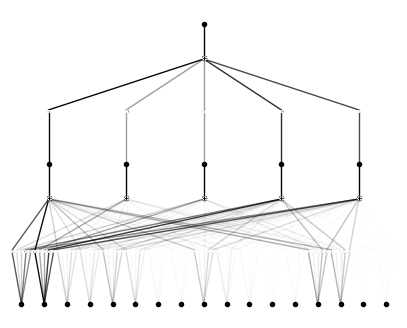

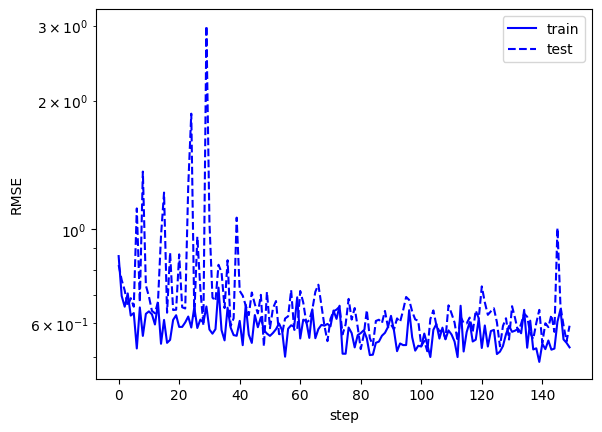

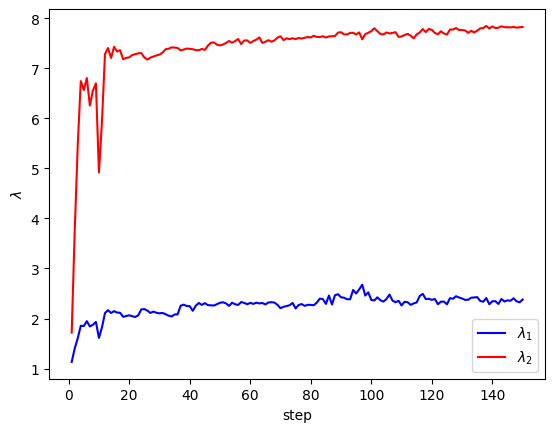

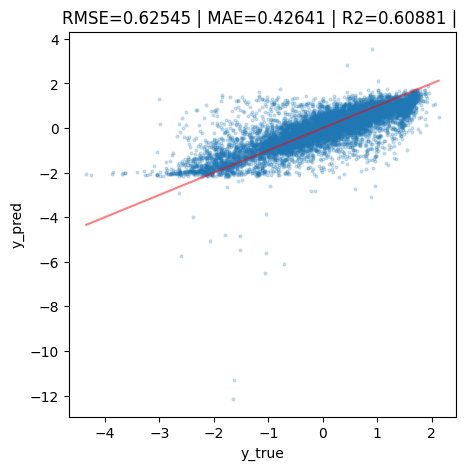

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.3788,  7.8235, -0.6076, -0.3944, -0.8508, -0.4948, -0.1082, -0.0727,
        -0.6456,  0.2585, -0.1032,  0.0323, -0.0782,  1.1237,  0.9564, -0.0116,
         0.0633], requires_grad=True)


In [5]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[n_var,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

PermutationExplainer explainer: 9983it [2:02:10,  1.36it/s]                            


module of Input importance:


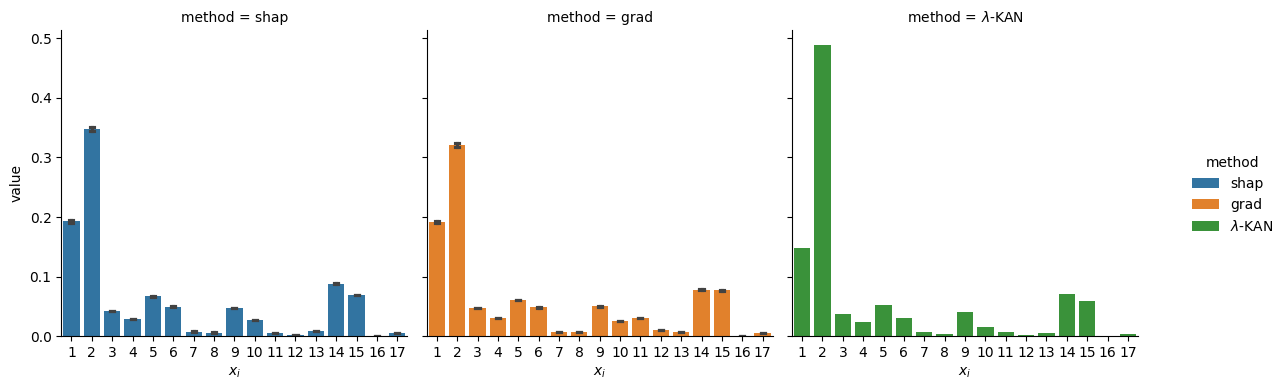

Input importance:


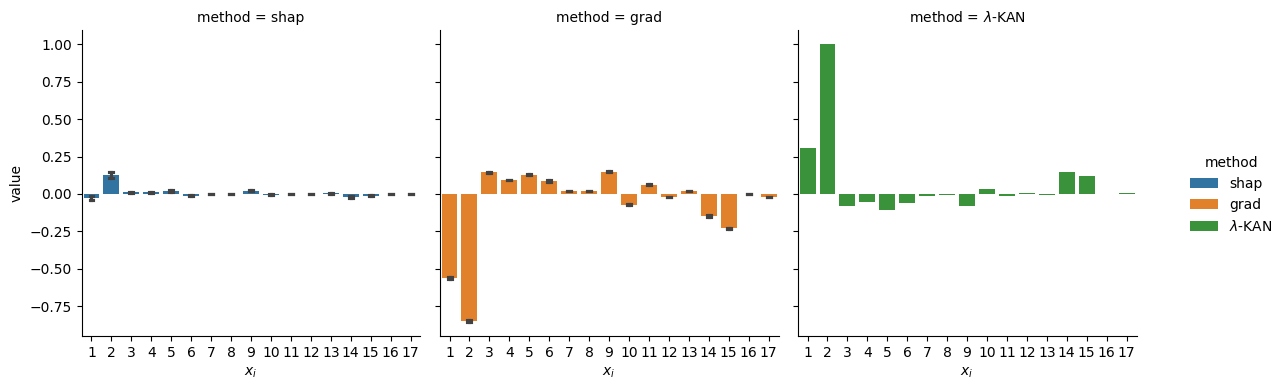

In [6]:
importance_analyse_lmdKAN(model, dataset)

In [ ]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')